In [24]:
import sys
import os
import pandas as pd
import numpy as np
import pymc

sys.path.append(f'{os.path.dirname(os.path.dirname(os.getcwd()))}/draft_pick_prob')

In [25]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv')
draft_df = pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_draft_order.csv')


mock_draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_BM_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_BM'})
mock_draft_df_2=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP'})
mock_draft_df_3=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_2CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP2'})
mock_draft_df_4=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_3CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP3'})
mock_draft_df_5=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_WW_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_W'})

possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_PLAYER_IDS.csv')

In [26]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv',encoding='ISO-8859-1')

file_list =['2019_BM_mockdraft.csv','2019_CP_mockdraft.csv','2019_2CP_mockdraft.csv','2019_3CP_mockdraft.csv','2019_WW_mockdraft.csv']

mock_draft_dfs = []


for filename in file_list:
    df = pd.read_csv(filename)  # Read the CSV file
    
    # Sort the DataFrame by 'RANK' column
    df = df.sort_values(by='RANK')
    
    prefix = filename[5:7]
        
    # Rename the 'RANK' column based on the extracted prefix
    if filename[-6:-4]== 'bb':
        df = df.rename(columns={'RANK': f'bb_RANK_{prefix}'})
    else:
        df = df.rename(columns={'RANK': f'md_RANK_{prefix}'})
    
    mock_draft_dfs.append(df)  # Add the processed DataFrame to the list



#possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv')
#draft_df
#possible_players

mock_draft_dfs[4]

,PLAYER_NAME,PLAYER_ID,md_RANK_WW
0,Jack Hughes,1,1
1,Kaapo Kakko,2,2
2,Alex Turcotte,5,3
3,Dylan Cozens,7,4
4,Bowen Byram,4,5
5,Trevor Zegras,9,6
6,Cole Caufield,15,7
7,Kirby Dach,3,8
8,Peyton Krebs,17,9
9,Matthew Boldy,12,10


In [27]:
import math
df_player_rankings=possible_players[['PLAYER_ID']].merge(mock_draft_dfs[0][['PLAYER_ID','md_RANK_BM']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[1][['PLAYER_ID','md_RANK_CP']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[2][['PLAYER_ID','md_RANK_2C']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[3][['PLAYER_ID','md_RANK_3C']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[4][['PLAYER_ID','md_RANK_WW']], how='left', on=['PLAYER_ID'])


df_player_rankings

,PLAYER_ID,md_RANK_BM,md_RANK_CP,md_RANK_2C,md_RANK_3C,md_RANK_WW
0,1,1.0,1.0,1.0,1.0,1.0
1,2,2.0,2.0,2.0,2.0,2.0
2,3,5.0,5.0,8.0,5.0,8.0
3,4,3.0,4.0,5.0,3.0,5.0
4,5,4.0,3.0,3.0,4.0,3.0
...,...,...,...,...,...,...
220,218,NaN,NaN,66.0,NaN,NaN
221,219,NaN,NaN,67.0,NaN,NaN
222,220,NaN,NaN,78.0,NaN,NaN
223,221,NaN,NaN,86.0,NaN,NaN


In [28]:
def likelihood(strengths, rankings):
    # params: vector of parameters [intercept, slope]
    likelihood=1
    counter=1
    paired_lists = list(zip(strengths, rankings))
    sorted_pairs = sorted(paired_lists, key=lambda x: x[1])
    sorted_list1, sorted_list2 = zip(*sorted_pairs)
    while counter<len(sorted_list2)+1 and sorted_list2[counter]!=sorted_list2[counter+1]:
        # print(np.exp(sorted_list1[counter-1]))
        # print(np.sum(np.exp(sorted_list1[counter-1:])))
        # print(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        likelihood+=np.log(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        counter+=1
    return likelihood

def neg_log_likelihood(params, df):
    neg_ll = 1  # Initialize as 0 for correct accumulation
    columns_to_go_through = df.columns[1:]
    for i in columns_to_go_through:
        max_rank = df[i].max() + 1
        player_rank = list(df[i])
        fixed_player_rank = [max_rank if math.isnan(x) else x for x in player_rank]
        
        # Determine the weighting factor based on column name
        if i.startswith('bb'):
            weight = 0.8  # Example: 0.5 for less value
        elif i.startswith('md'):
            weight = 1.0  # Example: 1.0 (or more) for 'md' columns
        else:
            weight = 1.0  # Default weight for other columns

        # Apply the weighting factor
        neg_ll -= weight * likelihood(params, fixed_player_rank)

    return neg_ll

In [29]:
def constraint_eq(x):
    return sum(x)

In [30]:
import scipy.optimize

counter=40
l_play=[]
variable_bounds=[]
count=0

while count<len(df_player_rankings):
    l_play.append(counter)
    count+=1
    counter-=0.20
    variable_bounds.append((-40,40))

result = scipy.optimize.minimize(neg_log_likelihood, l_play, args=(df_player_rankings,), method='SLSQP', bounds=variable_bounds, constraints={'type': 'eq', 'fun': constraint_eq})
print(result.x)

[ 4.00000000e+01  3.32849777e+01  2.29514970e+01  2.51560591e+01
  2.61346466e+01  1.72184523e+01  2.35509892e+01  1.88325428e+01
  2.18491870e+01  1.92494820e+01  1.75332516e+01  2.06203889e+01
  1.74326999e+01  1.83120242e+01  2.12646828e+01  1.81885213e+01
  2.14396525e+01  1.68856404e+01  1.36161865e+01  1.57772228e+01
  1.39004175e+01  1.50039514e+01 -2.07635374e+00  1.63398863e+01
  1.37311024e+01  1.48904648e+01  1.29365724e+01  1.71979950e+01
  1.38623306e+01  2.65336773e+00  1.41825272e+01  2.81706808e+00
  1.83274368e+01  1.63943471e+01  2.87651711e+00  2.91457680e+00
  2.73160311e+00  1.67537547e+01  2.54583661e+00  1.48573448e+01
  1.27038883e+01  2.54110685e+00  1.36736396e+01  1.34902904e+01
  1.30529069e+01  1.27039069e+01  2.88363527e+00  2.84507938e+00
  1.49560413e+01  2.69814886e+00  2.88818534e+00  1.28202229e+01
  3.04325264e+00  3.25131346e+00  3.49109585e+00  1.33475827e+01
  3.38213918e+00  2.93332701e+00  2.19100312e+00  1.20955902e+00
  9.97672478e-02 -1.02935

In [31]:
player_ability_parameters_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_PLAYER_IDS.csv')
player_ability_parameters_df['ABILITY_PARAMS']=result.x

player_ability_parameters_df=player_ability_parameters_df.sort_values(by='ABILITY_PARAMS', ascending=False, axis=0)
player_ability_parameters_df['SIM_RANK'] = range(1, len(player_ability_parameters_df) + 1)
player_ability_parameters_df.head(10)

,PLAYER_NAME,PLAYER_ID,ABILITY_PARAMS,SIM_RANK
0,Jack Hughes,1,40.000000,1
1,Kaapo Kakko,2,33.284978,2
4,Alex Turcotte,5,26.134647,3
3,Bowen Byram,4,25.156059,4
6,Dylan Cozens,7,23.550989,5
2,Kirby Dach,3,22.951497,6
8,Trevor Zegras,9,21.849187,7
16,Peyton Krebs,17,21.439652,8
14,Cole Caufield,15,21.264683,9
11,Matt Boldy,12,20.620389,10


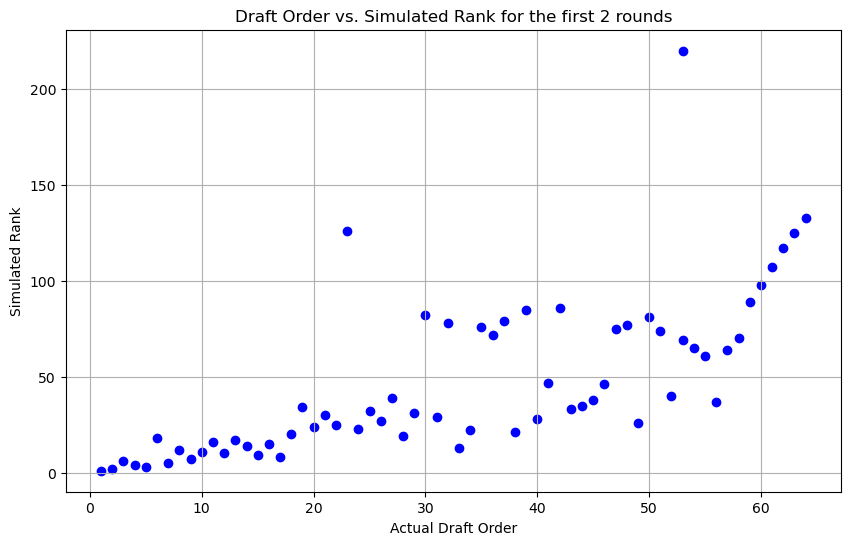

In [32]:
import matplotlib.pyplot as plt

# Assuming you have DataFrames: draft_df and player_ability_parameters_df

# Merge the two DataFrames on the 'PLAYER_NAME' column
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_ID', 'ORDER']], on='PLAYER_ID')
merged_df = merged_df.sort_values(by='ORDER')
merged_df
# Filter the data for the first 100 orders
merged_df_first_100 = merged_df.head(65)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_first_100['ORDER'], merged_df_first_100['SIM_RANK'], c='blue', label='Draft Order vs. Simulated Rank')
plt.xlabel('Actual Draft Order')
plt.ylabel('Simulated Rank')
plt.title('Draft Order vs. Simulated Rank for the first 2 rounds')
plt.grid(True)


plt.show()




In [33]:
#Error -Mean absolute error (MAE)
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_NAME', 'ORDER']], on='PLAYER_NAME')
merged_df = merged_df.sort_values(by='ORDER')
merged_df = merged_df.head(32)
merged_df['ERROR'] = abs(merged_df['SIM_RANK']-merged_df['ORDER'])
mae = merged_df['ERROR'].sum()/len(merged_df['ERROR'])
print(mae)


#equal gives 10.03 mae (only mds rn)



10.03125
